In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
from tqdm.auto import tqdm
from time_series import create_time_series
sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))
import fsrs_optimizer
import plotly.express as px
import numpy as np

tqdm.pandas()

In [42]:
# Median: 8798
# Most: 6810

df = pd.read_parquet(
    "../anki-revlogs-10k/revlogs", filters=[("user_id", "=", 6810)] 
)
df.size

31285744

In [43]:
df.drop(df[~df["rating"].isin([1, 2, 3, 4])].index, inplace=True)

In [44]:
df

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
291789,6272,0,4,0,7629,-1,-1,6810
291797,6273,0,4,0,4136,-1,-1,6810
291805,6274,0,4,0,4825,-1,-1,6810
291819,6276,0,4,0,2759,-1,-1,6810
291838,6278,0,4,0,4145,-1,-1,6810
...,...,...,...,...,...,...,...,...
3950933,81116,4567,2,2,14000,95,8176358,6810
3960867,81565,4567,2,2,24000,80,6913617,6810
3959000,81476,4567,2,2,15000,76,6543943,6810
3852347,76602,4567,2,2,3000,212,18313065,6810


In [45]:
df[df["card_id"] == 230]

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
9416,230,876,3,0,3061,-1,-1,6810
9417,230,876,4,1,1545,0,9473,6810
9418,230,879,3,2,1108,3,237602,6810
9419,230,888,2,2,2606,9,797491,6810
9420,230,898,3,2,1205,10,833211,6810
9421,230,921,3,2,1140,23,1981026,6810
9422,230,976,3,2,1336,55,4791737,6810
9423,230,1107,3,2,1222,131,11273287,6810
9424,230,1429,3,2,2893,322,27819195,6810
9425,230,2221,3,2,898,792,68421365,6810


In [46]:
df["prior_reviews"] = df.groupby("day_offset").cumcount()

In [47]:
print("creating time series")
df: pd.DataFrame = create_time_series(df)
print("training")
trainer = fsrs_optimizer.Trainer(df, df, fsrs_optimizer.DEFAULT_PARAMETER)
w = trainer.train()

creating time series
training


train:   0%|          | 0/1861034 [00:00<?, ?it/s]

iteration: 186112
w: [0.1976, 2.4057, 1.8495, 16.2853, 7.2378, 0.2716, 1.5215, 0.0066, 1.2819, 0.0, 0.7784, 1.7699, 0.2154, 0.2307, 2.2812, 0.9234, 3.3687, 0.341, 0.8008]
iteration: 372224
w: [0.0929, 2.7854, 1.2048, 16.4133, 6.8783, 0.2892, 1.6437, 0.0146, 1.3269, 0.0, 0.844, 1.7175, 0.2033, 0.2186, 2.3932, 0.9547, 3.3845, 0.4036, 1.0105]
iteration: 558336
w: [0.1166, 3.3994, 0.9734, 16.2259, 6.5893, 0.1783, 1.7131, 0.0163, 1.311, 0.0, 0.8402, 1.6072, 0.2254, 0.2215, 2.2771, 0.9869, 3.9171, 0.5408, 1.1527]
iteration: 744448
w: [0.1421, 3.4533, 0.9508, 16.2112, 6.4768, 0.1404, 1.7079, 0.0273, 1.2778, 0.0, 0.8142, 1.5053, 0.2284, 0.1987, 2.3028, 0.9833, 3.9108, 0.5752, 1.1821]
iteration: 930560
w: [0.0778, 3.6954, 0.9503, 16.1994, 6.3455, 0.2017, 1.6468, 0.0064, 1.28, 0.0, 0.8258, 1.4938, 0.2021, 0.22, 2.262, 0.9611, 4.0718, 0.544, 1.2007]
iteration: 1116672
w: [0.0983, 4.0057, 0.7264, 16.0307, 6.3433, 0.2695, 1.5938, 0.0174, 1.2476, 0.0, 0.7941, 1.4331, 0.2119, 0.1933, 2.2289, 0.9683, 

In [48]:
import math

DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def stability_after_success(s, r, d, rating):
    hard_penalty = w[15] if rating == 2 else 1
    easy_bonus = w[16] if rating == 4 else 1
    return max(
        0.01,
        s * (
            1
            + math.exp(w[8])
            * (11 - d)
            * (s ** -w[9])
            * (math.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        )
    )

def stability_after_failure(s, r, d):
    return max(
        0.01,
        min(
            w[11]
            * (d ** -w[12])
            * ((s + 1) ** w[13] - 1)
            * math.exp((1 - r) * w[14]),
            s / math.exp(w[17] * w[18])
        )
    )

def stability_short_term(s, init_rating=None):
    if init_rating is not None:
        rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[init_rating - 1]
        session_len = fsrs_optimizer.DEFAULT_FIRST_SESSION_LENS[init_rating - 1]
    else:
        rating_offset = fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET
        session_len = fsrs_optimizer.DEFAULT_FORGET_SESSION_LEN
    
    new_s = s * math.exp(
        w[17] * (rating_offset + session_len * w[18])
    )
    return new_s

def init_d(rating):
    return w[4] - math.exp(w[5] * (rating - 1)) + 1

def init_d_with_short_term(rating):
    rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[rating - 1]
    new_d = init_d(rating) - w[6] * rating_offset
    return max(1, min(new_d, 10))

def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9

def mean_reversion(target, value, alpha=0.5):
    return alpha * target + (1 - alpha) * value

def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return max(1, min(new_d, 10))


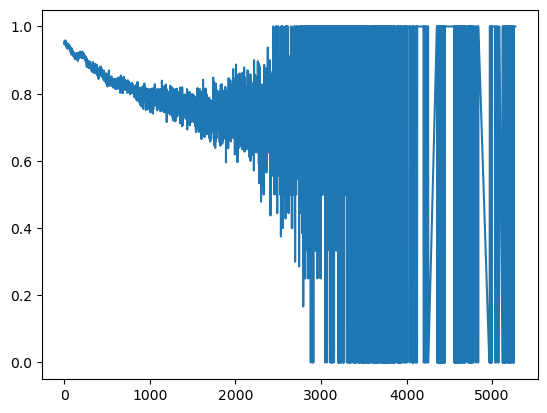

In [49]:
mean = df.groupby("prior_reviews")["y"].mean()
plt.plot(mean)
plt.show()

In [50]:
def memory_state(df):
    t_history = [int(t) for t in df["t_history"].split(",")]
    r_history = [int(r) for r in df["r_history"].split(",")]
    difficulty = None
    stability = None
    retrievability = 1e-10
    for delta_t, rating in zip(t_history, r_history):
        if stability is None:  # New card
            difficulty = init_d_with_short_term(rating)
            stability = stability_short_term(w[rating - 1], init_rating=rating)
        else:
            retrievability = power_forgetting_curve(delta_t, stability)
            if rating > 1:
                stability = stability_after_success(
                    stability, retrievability, difficulty, rating
                )
            else:
                stability = stability_after_failure(stability, retrievability, difficulty)
            difficulty = next_d(difficulty, rating)

    return stability, difficulty, retrievability


df["s"], df["d"], df["r"] = zip(*df.progress_apply(memory_state, axis=1))

  0%|          | 0/2327194 [00:00<?, ?it/s]

In [51]:
df["loss"] = df.apply(lambda df: (df["y"] - df["r"]) ** 2, axis=1)

In [52]:
df_filtered = df[(df["elapsed_days"] > 0) & (df["elapsed_days"] <= 21) & (df["r"] > 1e-9)]


Average Very Young cards per day 227.71578003586373


<Figure size 640x480 with 0 Axes>

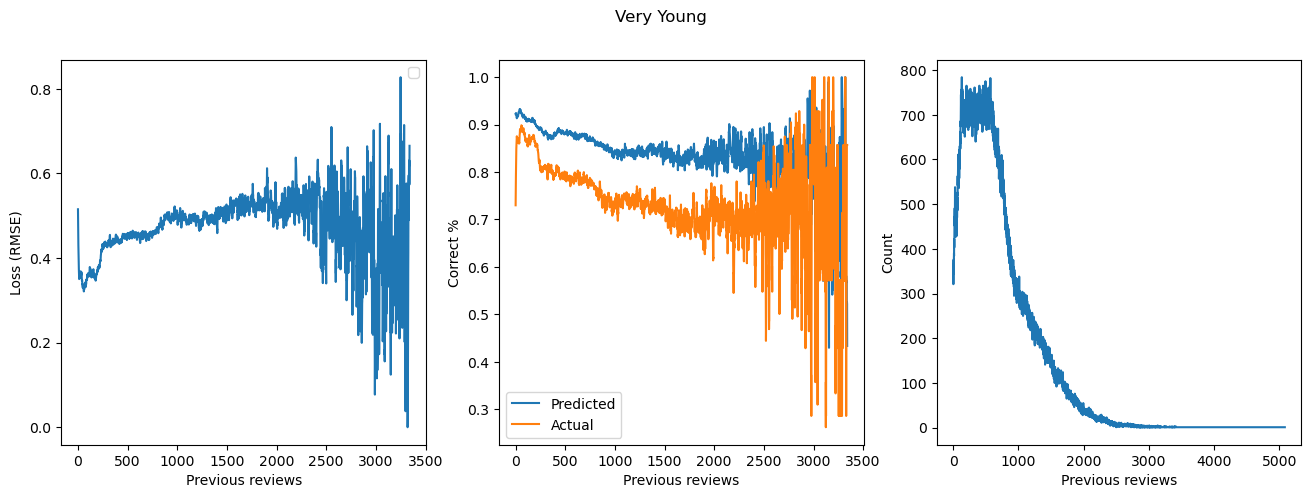

Average Young cards per day 367.464701511023


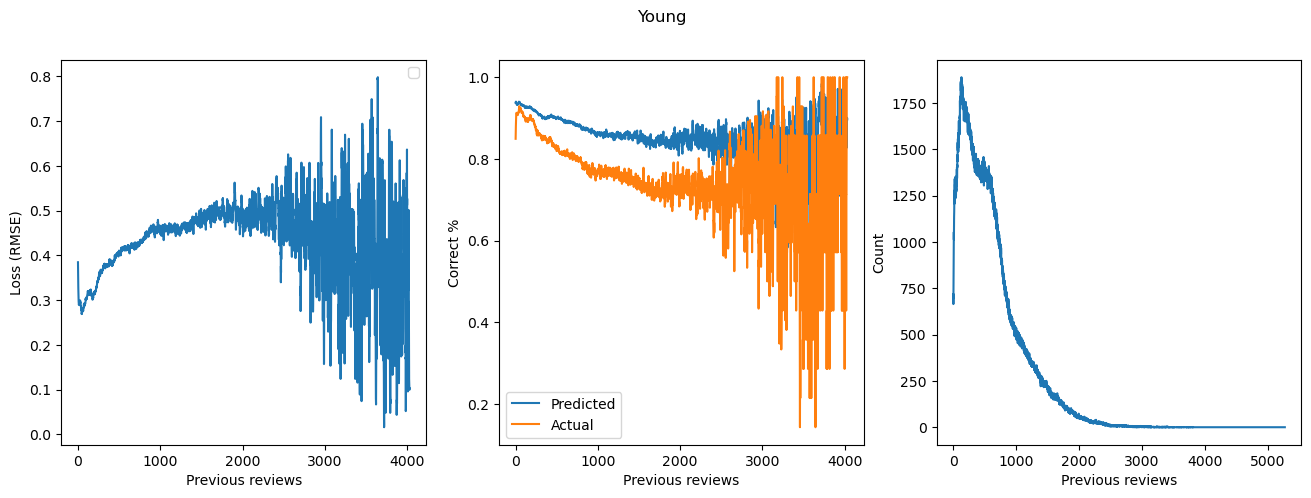

Average Mature cards per day 257.79336022339436


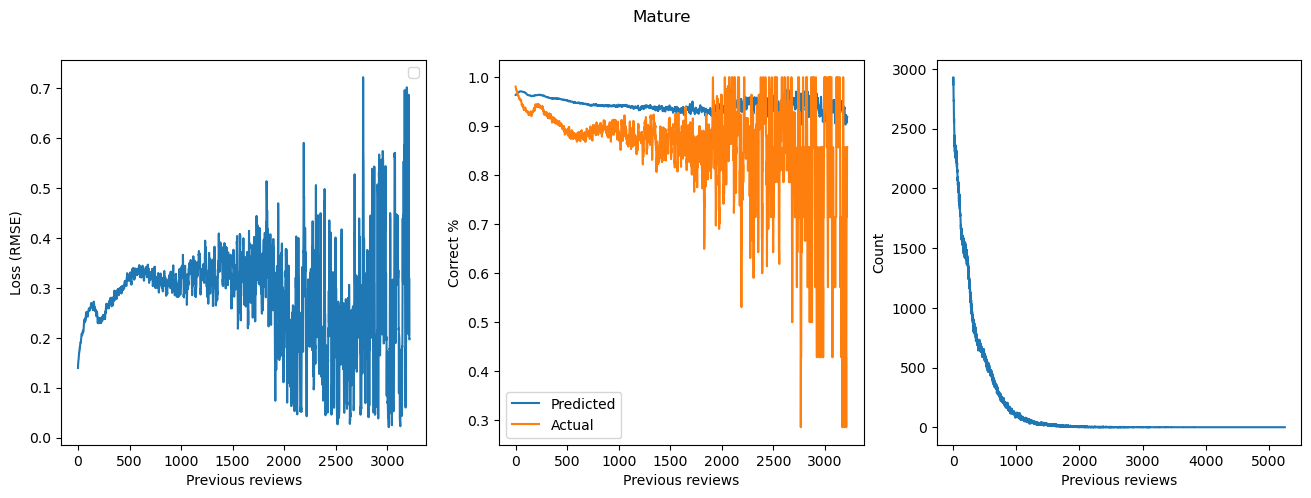

Average All cards per day 535.8469553137301


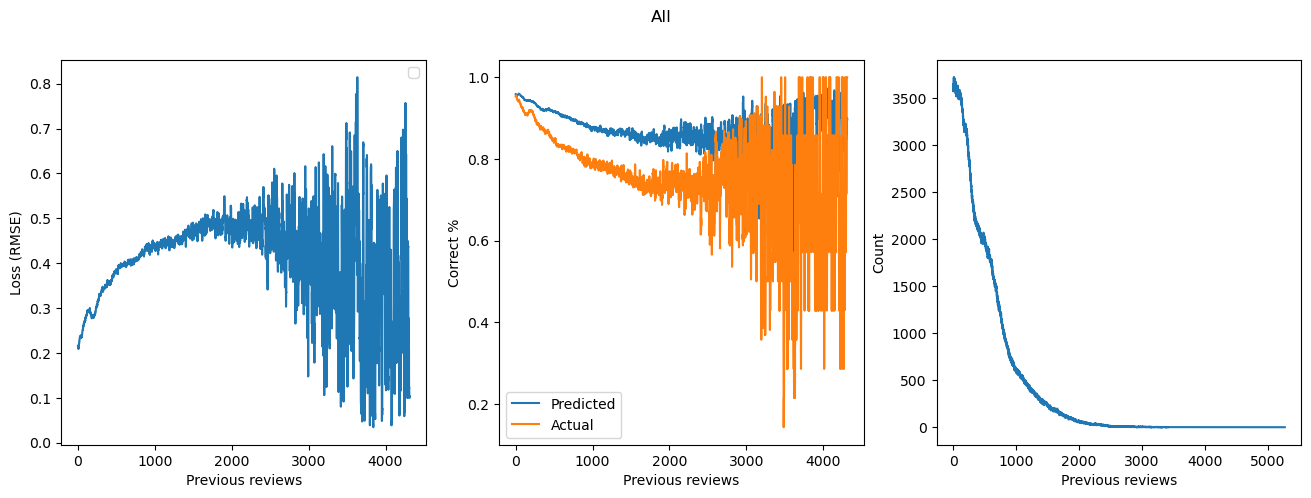

In [53]:
plt.clf()
categories = [
    #("Learn", -1, 1), 
    ("Very Young", 0, 4), 
    ("Young", 0, 21), 
    ("Mature", 21, 1e20),
    ("All", -1, 1e20)
]

# https://stackoverflow.com/a/54628145/24162642
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for name, lower, upper in categories:
    df_filtered = df[(df["elapsed_days"] > lower) & (df["elapsed_days"] <= upper) & (df["r"] > 1e-9)].groupby("prior_reviews")

    print(f"Average {name} cards per day {df_filtered['card_id'].count().mean()}")
    loss = df_filtered["loss"].mean() ** 0.5
    loss = moving_average(loss, 7)

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(name)
    ax1 = fig.add_subplot(131)

    ax1.set_xlabel('Previous reviews')
    ax1.set_ylabel('Loss (RMSE)')
    ax1.plot(loss)
    ax1.legend()

    ax2 = fig.add_subplot(132)

    ax2.plot(moving_average(df_filtered["r"].mean(), 7), label="Predicted")
    ax2.plot(moving_average(df_filtered["y"].mean(), 7), label="Actual")
    ax2.set_xlabel('Previous reviews')
    ax2.set_ylabel('Correct %')
    ax2.legend()

    ax3 = fig.add_subplot(133)

    ax3.plot(df_filtered["r"].count())
    ax3.set_xlabel('Previous reviews')
    ax3.set_ylabel('Count') # Number of days that the user had that many reviews or more

    plt.show()


In [54]:
fig = px.scatter_3d(df[(df["elapsed_days"] < 21) & (df["elapsed_days"] > 0)], x="prior_reviews", y="s", z="loss", range_y=(0, 21))
with open("out.html", "w") as f:
    f.write(fig.to_html())